In [23]:
from src.transforms import MFCCSumTransform, SpectrogramDBTransform, PseudoCQTTransform
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import librosa
import nnAudio.Spectrogram
import torch
import yaml

In [19]:
# audio, sr = torchaudio.load("dataset/clean/guitarset_5s/00_BN1-129-Eb_comp_1.wav")
audio, sr = torchaudio.load("dataset/generated/gen_singleFX_1onN_09182021/valid/audio/45.wav")

In [ ]:
transform = MFCCSumTransform(sr, 40, {"n_mels": 64})
output = transform(audio)
plt.stem(output[0])

torch.Size([1, 128, 216])


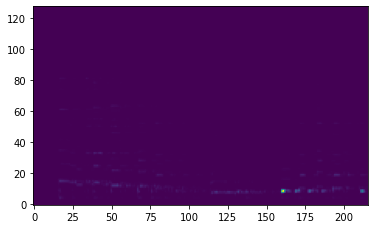

In [60]:
meller = torchaudio.transforms.MelSpectrogram(44100, n_fft=2048, n_mels=128)
output = meller(audio)
print(output.shape)
plt.imshow(output[0], origin='lower')

torch.Size([1, 257, 862])


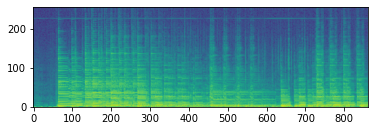

In [6]:
specer = SpectrogramDBTransform(n_fft=512)
output = specer(audio)
print(output.shape)
plt.imshow(output[0], origin='lower')

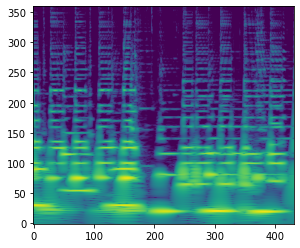

In [13]:
output = librosa.cqt(audio[0].numpy(), sr=44100, fmin=82.41, n_bins=360, bins_per_octave=60)
plt.imshow(librosa.amplitude_to_db(np.abs(output)), origin='lower')

CQT kernels created, time used = 0.3531 seconds
torch.Size([1, 220500])
torch.Size([1, 360, 431])


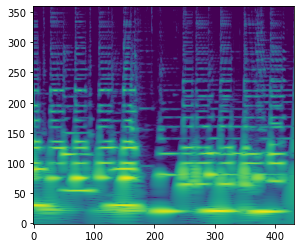

In [20]:
nnaudio_cqter = nnAudio.Spectrogram.CQT(sr=44100, fmin=82.41, n_bins=360, bins_per_octave=60)
print(audio.shape)
output = nnaudio_cqter(audio)
print(output.shape)
plt.imshow(librosa.amplitude_to_db(np.abs(output[0])), origin='lower')

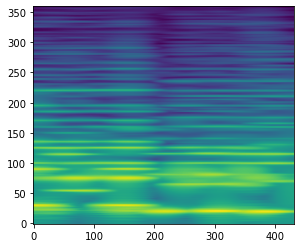

In [18]:
output = librosa.pseudo_cqt(audio[0].numpy(), sr=44100, fmin=82.41, n_bins=360, bins_per_octave=60, hop_length=512)
plt.imshow(librosa.amplitude_to_db(np.abs(output)), origin='lower')

/opt/conda/lib/python3.8/site-packages/scipy/sparse/data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


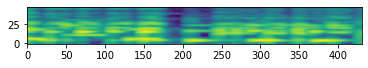

In [9]:
cqter = PseudoCQTTransform()
output = cqter(audio)
plt.imshow(output[0].numpy(), origin='lower')

In [27]:
fx_params = [1,2,3,4,5,6,7]

In [28]:
with open('test.yml', 'w') as outfile:
    yaml.dump(fx_params, outfile, default_flow_style=False)

In [ ]:
from itertools import combinations
fx_params = [0,1,2,3,4,5,6]
combinations(fx_params)